<a href="https://colab.research.google.com/github/ezemaudet/TP_NLP1/blob/main/Desafio__3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [3]:
raw_html = urllib.request.urlopen('https://www.textos.info/franz-kafka/la-metamorfosis/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [4]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' cuando gregorio samsa se despertó una mañana después de un sueño \r\nintranquilo, se encontró sobre su cama convertido en un monstruoso \r\ninsecto. estaba tumbado sobre su espalda dura, y en forma de caparazón \r\ny, al levantar un poco la cabeza veía un vientre abombado, parduzco, \r\ndividido por partes duras en forma de arco, sobre cuya protuberancia \r\napenas podía mantenerse el cobertor, a punto ya de resbalar al suelo. \r\nsus muchas patas, ridículamente pequeñas en comparación con el resto de \r\nsu tamaño, le vibraban desamparadas ante los ojos. «¿qué me ha ocurrido?», pensó. no era un sueño. su habitación, una auténtica habitación humana, si \r\nbien algo pequeña, permanecía tranquila entre las cuatro paredes harto \r\nconocidas. por encima de la mesa, sobre la que se encontraba extendido \r\nun muestrario de paños desempaquetados —samsa era viajante de comercio—,\r\n estaba colgado aquel cuadro que hacía poco había recortado de una \r\nrevista y había colocado en un bonit

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [5]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [6]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [7]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [8]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

60

In [9]:
chars_vocab

{'\t',
 '\n',
 '\r',
 ' ',
 '!',
 '(',
 ')',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 ':',
 ';',
 '?',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '¡',
 '«',
 '»',
 '¿',
 'á',
 'é',
 'í',
 'ñ',
 'ó',
 'ú',
 'ü',
 '—'}

In [10]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [11]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [12]:
tokenized_text[:1000]

[16,
 6,
 49,
 11,
 15,
 51,
 17,
 16,
 40,
 12,
 46,
 40,
 17,
 12,
 35,
 17,
 16,
 47,
 11,
 50,
 47,
 11,
 16,
 47,
 46,
 16,
 51,
 46,
 47,
 57,
 46,
 12,
 44,
 39,
 16,
 49,
 15,
 11,
 16,
 50,
 11,
 21,
 11,
 15,
 11,
 16,
 51,
 46,
 47,
 57,
 49,
 30,
 47,
 16,
 51,
 46,
 16,
 49,
 15,
 16,
 47,
 49,
 46,
 21,
 17,
 16,
 45,
 59,
 35,
 15,
 44,
 12,
 11,
 15,
 52,
 49,
 35,
 9,
 17,
 2,
 16,
 47,
 46,
 16,
 46,
 15,
 6,
 17,
 15,
 44,
 12,
 39,
 16,
 47,
 17,
 4,
 12,
 46,
 16,
 47,
 49,
 16,
 6,
 11,
 50,
 11,
 16,
 6,
 17,
 15,
 48,
 46,
 12,
 44,
 35,
 51,
 17,
 16,
 46,
 15,
 16,
 49,
 15,
 16,
 50,
 17,
 15,
 47,
 44,
 12,
 49,
 17,
 47,
 17,
 16,
 45,
 59,
 35,
 15,
 47,
 46,
 6,
 44,
 17,
 19,
 16,
 46,
 47,
 44,
 11,
 4,
 11,
 16,
 44,
 49,
 50,
 4,
 11,
 51,
 17,
 16,
 47,
 17,
 4,
 12,
 46,
 16,
 47,
 49,
 16,
 46,
 47,
 57,
 11,
 9,
 51,
 11,
 16,
 51,
 49,
 12,
 11,
 2,
 16,
 36,
 16,
 46,
 15,
 16,
 20,
 17,
 12,
 50,
 11,
 16,
 51,
 46,
 16,
 6,
 11,
 57,
 11,
 12,

### Organizando y estructurando el dataset

In [13]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [14]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [15]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [16]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [17]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [18]:
X.shape

(112059, 100)

In [19]:
X[0,:10]

array([16,  6, 49, 11, 15, 51, 17, 16, 40, 12])

In [20]:
y[0,:10]

array([ 6, 49, 11, 15, 51, 17, 16, 40, 12, 46])

In [21]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [22]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential
from keras.layers import LSTM
from keras.layers import GRU

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [23]:
model = Sequential()


model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))

#SimpleRNN
#model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))

#LSTM
model.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))

#GRU
#model.add(GRU(120, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))

model.add(Dense(vocab_size, activation='softmax'))
#model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 60)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 100)      │        64,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 60)       │         6,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,460 (275.23 KB)

 Trainable params: 70,460 (275.23 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [24]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [25]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 3.0004
 mean perplexity: 9.695679722762689 

Saved new model!
438/438 ━━━━━━━━━━━━━━━━━━━━ 147s 312ms/step - loss: 2.9996
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 2.1577
 mean perplexity: 8.43229483395088 

Saved new model!
438/438 ━━━━━━━━━━━━━━━━━━━━ 133s 303ms/step - loss: 2.1576
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 2.0005
 mean perplexity: 7.8897803895841765 

Saved new model!
438/438 ━━━━━━━━━━━━━━━━━━━━ 141s 302ms/step - loss: 2.0004
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 1.9030
 mean perplexity: 7.608859254092705 

Saved new model!
438/438 ━━━━━━━━━━━━━━━━━━━━ 144s 307ms/step - loss: 1.9029
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 1.8350
 mean perplexity: 7.429644041914281 

Saved new model!
438/438 ━━━━━━━━━━━━━━━━━━━━ 135s 309ms/step - loss: 1.8350
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 1.7812
 mean perpl

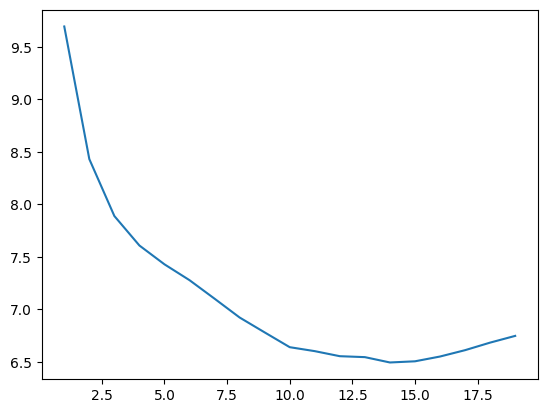

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [27]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción del próximo caracter

In [28]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 122.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.7 MB/s eta 0:00:00


In [29]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e1507b9d9bbc99a02c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e1507b9d9bbc99a02c.gradio.live


### Generación de secuencias

In [30]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [31]:
input_text='gregorio samsa se despertó'

generate_seq(model, input_text, max_length=max_context_size, n_words=40)

'gregorio samsa se despertó de la hermana y se había alguna de la h'

###  Beam search y muestreo aleatorio

In [32]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [33]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [34]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="gregorio samsa se despertó una")

In [35]:
salidas[0]

array([40, 12, 46, 40, 17, 12, 35, 17, 16, 47, 11, 50, 47, 11, 16, 47, 46,
       16, 51, 46, 47, 57, 46, 12, 44, 39, 16, 49, 15, 11, 16, 57, 49, 46,
       12, 44, 11, 16, 51, 46, 16,  9, 11, 16, 23, 46, 12, 50, 11, 15])

In [36]:
# veamos las salidas
decode(salidas[0])

'gregorio samsa se despertó una puerta de la herman'

#**Resumen Modelos**

GROUND TRUTH

gregorio samsa se despertó una mañana después de un sueño \r\nintranquilo

#SimpleRNN contexto 100
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
 Total params: 63,859 (249.45 KB)
 Trainable params: 63,859 (249.45 KB)
 Non-trainable params: 0 (0.00 B)

Epoch 11/20
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5461
 mean perplexity: 6.271519294599208

Stopping training...
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 1.5461

Generacion de secuencia

gregorio samsa se despertó de la cama a su habitación de la cabeza

Beam search y muestreo aleatorio

gregorio samsa se despertó una gregorio se encontr

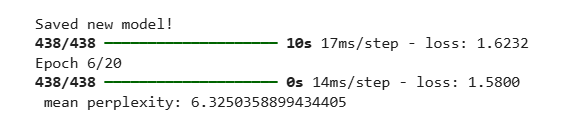

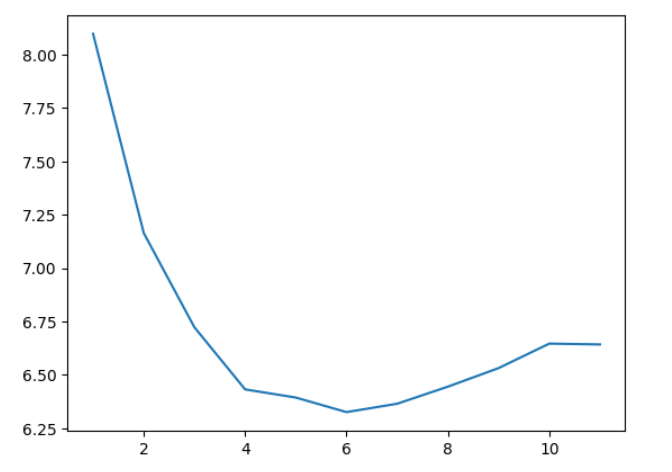

 #SimpleRNN  contexto 60

model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))

Total params: 63,859 (249.45 KB)
 Trainable params: 63,859 (249.45 KB)
 Non-trainable params: 0 (0.00 B)

 Epoch 9/20
433/438 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5437
 mean perplexity: 5.989739319074501

Saved new model!
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 1.5437
Epoch 10/20
434/438 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5305
 mean perplexity: 6.036504836915766

Generacion de Secuencia

 gregorio samsa se despertó en la habitación de la habitación de la

Beam search y muestreo aleatorio

 gregorio samsa se despertó una vez en la habitació

 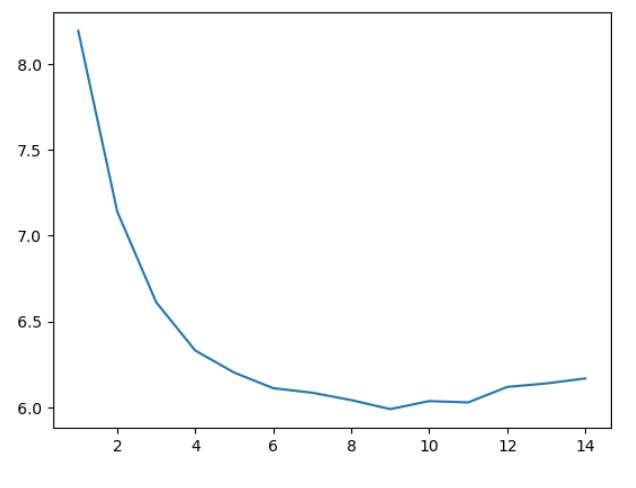

#LSTM

model.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
Puse 100 neuronas para que el total de parametros fueran semejantes. Igualmente el tiempo de entranamiento fue mucho mayor.  

 Total params: 69,959 (273.28 KB)
 Trainable params: 69,959 (273.28 KB)
 Non-trainable params: 0 (0.00 B)

 Epoch 20/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 1.6964
 mean perplexity: 6.997034146533749

Saved new model!
438/438 ━━━━━━━━━━━━━━━━━━━━ 146s 314ms/step - loss: 1.6964

 Generacion de secuencia

 gregorio samsa se despertó de la había \r\npara en la había \r\npara e

 Beam search y muestreo aleatorio

 gregorio samsa se despertó una de la habitación de


 Saved new model!
438/438 ━━━━━━━━━━━━━━━━━━━━ 148s 298ms/step - loss: 1.4966
Epoch 14/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 1.4685
 mean perplexity: 6.49454565552192

 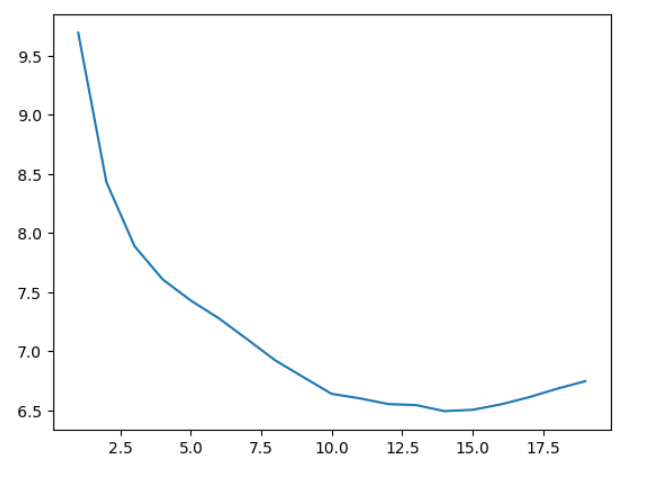

#SimpleRNN + LSTM
con 100 nodos y contexto 200. El perplexity empeoro.

 Total params: 178,359 (696.71 KB)
 Trainable params: 178,359 (696.71 KB)
 Non-trainable params: 0 (0.00 B)

437/437 ━━━━━━━━━━━━━━━━━━━━ 381s 859ms/step - loss: 1.3584
Epoch 9/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - loss: 1.3359
 mean perplexity: 10.602631568908691

Stopping training...
437/437 ━━━━━━━━━━━━━━━━━━━━ 374s 855ms/step - loss: 1.3359

Generacion de la secuencia
gregorio samsa se despertó de la cama y en la habitación de la cam

Beam search y muestreo aleatorio
gregorio samsa se despertó una vez en la habitació

#GRU
model.add(GRU(120, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
Puse 120 neuronas para que el total de parametros fueran semejantes. Igualmente el tiempo de entranamiento fue mucho mayor.

 Total params: 72,299 (282.42 KB)
 Trainable params: 72,299 (282.42 KB)
 Non-trainable params: 0 (0.00 B)

 Epoch 12/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 1.4347
 mean perplexity: 6.580179724266858

Stopping training...
438/438 ━━━━━━━━━━━━━━━━━━━━ 148s 303ms/step - loss: 1.4347

Generacion de la Secuencia

gregorio samsa se despertó a la hermana en la hermana en la herman

Beam search y muestreo aleatorio

gregorio samsa se despertó una habitación de la he

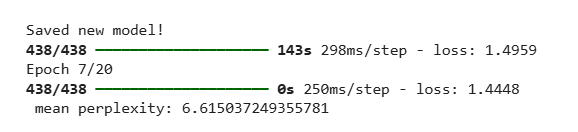

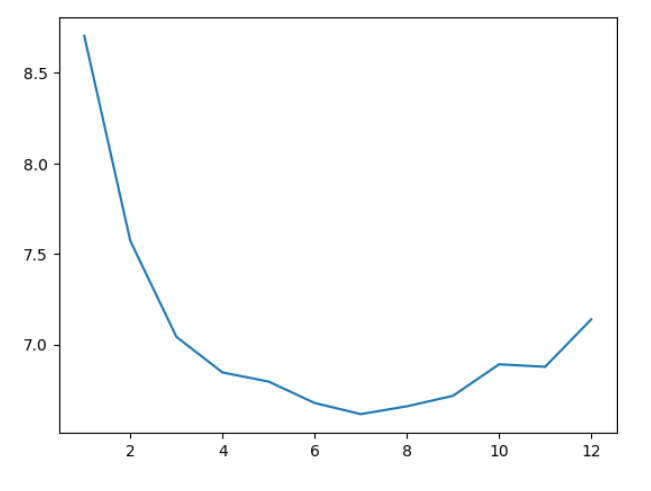

 #**GRU**

 Mas nodos 200 y mas contexto 200
model.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
Puse 200 neuronas para que el total de parametros fueran semejantes. Igualmente el tiempo de entranamiento fue mucho mayor.

Total params: 168,459 (658.04 KB)
 Trainable params: 168,459 (658.04 KB)
 Non-trainable params: 0 (0.00 B)

 Epoch 7/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - loss: 1.2394
 mean perplexity: 10.730637550354004

Stopping training...
437/437 ━━━━━━━━━━━━━━━━━━━━ 265s 520ms/step - loss: 1.2393

Generacion de la Secuencia
 gregorio samsa se despertó a la habitación de la habitación de la
Beam search y muestreo aleatorio
 gregorio samsa se despertó una habitación de la ha


 El modelo no mejoro. Al contrario la perplejidad empezo a diverger.

 Probe con Contexto 100 y 200 nodos y el modelo se comporto como el anterior divergio y llego a una perplexity mayor.

  Total params: 168,459 (658.04 KB)
 Trainable params: 168,459 (658.04 KB)
 Non-trainable params: 0 (0.00 B)

 438/438 ━━━━━━━━━━━━━━━━━━━━ 141s 290ms/step - loss: 1.2515
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 1.2139
 mean perplexity: 7.990786141496364

Stopping training...
438/438 ━━━━━━━━━━━━━━━━━━━━ 149s 306ms/step - loss: 1.2139

Generacion de la Secuencia
gregorio samsa se despertó a la madre y la hermana en la madre y l

Beam search y muestreo aleatorio
gregorio samsa se despertó una puerta de la herman

#**Concluciones:**
Se probaron los 3 modelos con una cantidad de nodos diferentes para igualar la cant de parametros totales.

En las series temporales hay una regla 80/20 es decir que solo se puede predecir hasta un 20% del historial que se tiene. Es decir de un contexto de 100 caracteres se podria predecir hasta unos 20. En nuestro caso los modelos solo predecian aceptablemente hasta 1 caracteres para adelante.

SimpleRNN A pesar de tener menor profundidad semántica, el modelo SimpleRNN logró la perplejidad mas baja y una secuencia coherente aunque repetitiva. Su velocidad de entrenamiento fue la más rápida.Aumentar el contexto no ayudo a la generalizacion ni mejoro las construcciones gramaticales. Todo lo contrario al bajar el contexto a 60 se mantuvieron los resultados y el modelo convergio mas rapido.

LSTM Aunque más potente en teoría, el LSTM presentó la mayor perplejidad de los tres. La secuencia generada fue menos coherente y tendió a bucles gramaticales. Su tiempo de entrenamiento fue significativamente mayor.

El GRU ofreció el mejor balance entre rendimiento y calidad generativa. Aunque no alcanzó la secuencia original exacta, produjo construcciones gramaticales mas reales y con mayor consistencia semántica que LSTM o SimpleRNN.



Se probo con optimizador ADAM sin lograr mejoras
LSTM
Epoch 10/20
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4973
 mean perplexity: 7.111439708771744

Stopping training...
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 1.4973